# カメラ・キャリブレーション

## 目的

このセクションでは
* カメラの歪み(内部パラメータや外部パラメータなど)を学ぶ．
* これらのパラメータの推定方法や画像の歪みを取り除く方法などを学ぶ．

## 基礎

最近の安いピンホール・カメラは画像上に多くの歪みを生じさせてしまう．主な歪みとして放射状歪み(radial distortion)と接線歪み(tangential distortion)が挙げられる．

放射状歪みは直線が曲線になるような歪みである．画像中心から離れれば離れるほど歪みは大きくなる．以下に示す画像を見てみよう．チェスボードのエッジに沿って赤い線を書いたが，チェスボードの境界線が直線ではなく，さきほど描いた赤い線と厳密には一致していないのが分かるかと思う．直線として見えるはずのものが全て膨れてしまう．詳細については [歪み(光学) (英語)](http://en.wikipedia.org/wiki/Distortion_%28optics%29) を参照しよう．

![](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/_images/calib_radial.jpg)

放射状歪みは以下のようにして補正できる:

$x_{corrected} = x( 1 + k_1 r^2 + k_2 r^4 + k_3 r^6)$ <BR>
$y_{corrected} = y( 1 + k_1 r^2 + k_2 r^4 + k_3 r^6)$

同様にもう一つの歪みである接線歪みは，レンズと画像平面が完璧に平行になっていないことが原因で生じる歪みである．そのため，ある領域が期待しているよりも近くにあるように見えてしまう．接線歪みの補正方法は以下である:

$x_{corrected} = x + [ 2p_1xy + p_2(r^2+2x^2)] $ <BR>
$y_{corrected} = y + [ p_1(r^2+ 2y^2)+ 2p_2xy]$

要するに，次の式に示す5個のレンズ歪みパラメータを推定しなければならない:

$Distortion \; coefficients=(k_1 \hspace{10pt} k_2 \hspace{10pt} p_1 \hspace{10pt} p_2 \hspace{10pt} k_3)$

さらに，カメラの内部パラメータや外部パラメータといった情報も必要になる． <B>内部パラメータ(Intrinsic parameters)</B> とはカメラ固有のパラメータを指し，焦点距離 ($f_x,f_y$)，光学中心, ($c_x, c_y$) などである．内部パラメータはカメラ行列とも呼ばれる．このパラメータはカメラ固有のものであるため，一度計算すればそれ以降保存した値を使い．内部パラメータは3x3の行列として以下のように表される:

$camera \; matrix = \left [ \begin{matrix}   f_x & 0 & c_x \\  0 & f_y & c_y \\   0 & 0 & 1 \end{matrix} \right ]$

<B>外部パラメータ(extrinsic parameters)</B>とは、ある座標系における3次元点の座標を別の座標系での座標に変換するための回転と並進のパラメータのことである．

立体視のようなアプリケーションを作るには，まず初めにこのような歪みを解消(補正)する必要がある．これらのパラメータを推定するにはチェスボードのように，歪みがない場合にどのように見えるか規定できる画像を何枚か用意する．そしてその画像の中で(チェスボードでは四角形の角のような)特定の点をいくつか見つける．実空間中でそれらの位置がわかっており、画像における位置もわかっている．このようなデータを基にして，数学問題を解いて歪みパラメータを推定する．これがカメラ・キャリブレーションの概要である．良い結果を得るには，少なくとも10枚程度の画像が必要である．

## 実装(コード

上で述べたように，カメラ・キャリブレーションを(精度よく)行うには少なくとも10枚程度の画像が必要である．OpenCVはチェスボードを撮影した画像を用意しているので(OpenCVをインストールしたフォルダの samples/cpp/left01.jpg -- left14.jpg である), このサンプル画像を使おう(インストールしていない人はzipファイルをダウンロードして展開すること)．理解しやすくするために，今は1枚の画像だけを考えよう．カメラ・キャリブレーションに必要なデータは、3次元空間中での点の集合と，それぞれの点に対応する画像中の2次元点の位置である．2次元点は画像中から容易に検出できる(チェスボード上の二つの黒い四角形の交点を指す)．

では，3次元空間中での3次元点の位置はどうすればいいだろうか？これらの画像は，固定してあるカメラの前でチェスボードの位置や姿勢を色々と変えて撮影された画像である．そのため，我々が知らなければならない情報は、3次元点の位置 (X,Y,Z) である．これらの画像を，XY平面上に固定されたチェスボード(すなわち全ての点に対してZ=0)をカメラの位置・姿勢を変えて撮影した画像だとみなして考えてみよう．このように考えると，知らなければならない3次元点の位置は、実際にはXとYの位置さえわかれば良いことになる．チェスボードは白黒の格子パターンが交互に並んでいるパターンなので，XとYの位置は(0,0), (1,0), (2,0), ... と簡単に計算できる．この時，格子パターンのサイズが結果に含まれるが，今我々が使用するサンプル画像の場合、格子のサイズを30mmだとしよう．そうすると，制御点の3次元点位置のX,Y座標は (0,0),(30,0),(60,0),..., となり，結果を㎜単位で得ることができる。

なお、3次元点は <B>対象点(object points) </B>2次元画像上の点は <B>画像点(image points)</B> という．

<IMG SRC="http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/py_tutorials/py_calib3d/py_pose/chessboards/left01.jpg" width="400" align="left" />  <IMG SRC="http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/py_tutorials/py_calib3d/py_pose/chessboards/left14.jpg" width="400" align="right" />

## 設定

画像からチェスボード上の格子点を検出するには [cv2.findChessboardCorners(image, patternSize{, corners{, flags}})](http://docs.opencv.org/3.0-beta/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html?highlight=cv2.findchessboardcorners#cv2.findChessboardCorners) 関数を使う．引数(patternSize)により、どのようなパターン(例えば8x8の格子とか7x5の格子とか)を見つけたいかを指定する必要がある．この例では7x6の格子パターンである(普通のチェスボードは8x8の四角形，7x7の制御点を持つ)．この関数は２つの出力を返す．1つ目は二値のフラグで，指定したパターンが画像中から検出されればTrueとなる．２つ目は検出された制御点の座標であり、画像中の左から右，上から下にソートされている．

注意： この関数は、与えられた全ての画像に対し、検出したいパターンを検出できるとは限らない．そのため，カメラを起動させたらフレームごとにパターンが検出できるかどうか確認すると良い．パターンを見つけられたら、検出した制御点の情報をリストに登録する．また次のフレームを読み込むのに時間間隔をあけるようにすれば、チェスボードの位置や向きを調整できる．この処理を、十分な枚数の画像が取得できるまで繰り返す．このサンプル画像の14枚でさえ、何枚使えるかどうか保証はない．そのため，全部の画像を入力し，その中で良いものだけを使うようにする．


注意: チェスボードではなく格子状に並んだ円のパターンを使う事もできる．その場合， [cv2.findCirclesGrid()](http://docs.opencv.org/3.0-beta/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html?highlight=cv2.findcircle#cv2.findCirclesGrid) 関数を使ってパターンを検出する．円パターンを使うと，より少ない画像枚数でも十分な精度が得られると言われている．

コーナー検出をした後に [cv2.cornerSubPix()](http://docs.opencv.org/3.0-beta/modules/imgproc/doc/feature_detection.html?highlight=cv2.cornersubpix#cv2.cornerSubPix) 関数を使うと，検出精度を向上できる．また， [cv2.drawChessboardCorners()](http://docs.opencv.org/3.0-beta/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html?highlight=cv2.drawchessboardcorners#cv2.drawChessboardCorners) 関数を使えば，検出した制御点の位置を画像上に描画できる．上記の全てを実装すると，コードは以下のようになる: (注意:[画像のzipファイル](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/py_tutorials/py_calib3d/py_calibration/chessboards.zip)をダウンロードし、展開しておくこと)

In [1]:

import numpy as np
import cv2
import glob

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('chessboards/*.jpg')

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (7,6),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (7,6), corners2,ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

# Notebookの場合はこれが必要
for _ in range(5):
    cv2.waitKey(1)

サンプル画像の1枚に対する結果の画像は以下:
![](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/_images/calib_pattern.jpg)

## キャリブレーション(Calibration)

対象点と画像点が得られたので，キャリブレーションができるようになった．そのために使う関数は [cv2.calibrateCamera()](http://docs.opencv.org/3.0-beta/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html?highlight=cv2.calibratecamera#cv2.calibrateCamera) である。戻り値はブール値ret、カメラ行列(内部パラメータ)mtx，レンズ歪みパラメータdist，回転ベクトルrvecs, 並進ベクトルtvecsである:

In [2]:
import numpy as np
import cv2
import glob

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('chessboards/*.jpg')

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (7,6),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (7,6), corners2,ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

#cv2.destroyAllWindows()

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

# saving the data as dict
np.savez('Points.npz',objpoints=objpoints,imgpoints=imgpoints)
np.savez('B.npz',mtx=mtx, dist=dist, rvecs=rvecs, tvecs=tvecs)


注: キャリブレーションの結果（カメラ行列やレンズ歪みパラメータなど）を再利用する機会が多い(次の「歪み補正」や次章の「姿勢推定」など)。 Numpyの関数([numpy.savez()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.savez.html#numpy.savez)や [numpy.load()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.load.html#numpy.load)など)を用いてパラメータを記憶しておくと便利である。

## 歪み補正(Undistortion)

キャリブレーションにより，画像からレンズ歪みの影響を取り除くことができる．OpenCVは歪み補正のために関数を2つ用意している．それぞれの関数を紹介する前に， [cv2.getOptimalNewCameraMatrix()](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/py_tutorials/py_calib3d/py_calibration/py_calibration.html) 関数を使ってカメラ行列(内部パラメータ)を改善す．スケーリングパラメータ `alpha=0` であれば, この関数は期待しない画素の数を最小にする補正画像を返す．画像の角にある画素まで消してしまう．一方で， `alpha=1` を与えると黒い画素が外挿される．更に結果を切り出すためのROIも返す．

それでは新しい画像(今回は left12.jpg である．このチュートリアルでは最初の画像である)を使おう．

In [3]:
img = cv2.imread('chessboards/left12.jpg')
h,  w = img.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

In [7]:
print("h=%d, w=%d"%(h,w))

h=480, w=640


In [14]:
print("roi=",roi,"\nnewcameramtx="),print(newcameramtx)

roi= (11, 22, 614, 437) 
newcameramtx=
[[457.58605957   0.         343.35092644]
 [  0.         456.00552368 234.06247184]
 [  0.           0.           1.        ]]


(None, None)

(1). [cv2.undistort()](http://docs.opencv.org/3.0-beta/modules/imgproc/doc/geometric_transformations.html?highlight=cv2.undistort#cv2.undistort) 関数を使う

最短で歪み補正を行う方法である．[cv2.undistort()](http://docs.opencv.org/3.0-beta/modules/imgproc/doc/geometric_transformations.html?highlight=cv2.undistort#cv2.undistort)関数を呼び，結果の切り出しには関数が出力するROIを使う．

In [22]:
# 歪補正
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

# 画像の切り落とし
x,y,w,h = roi
dst = dst[y:y+h, x:x+w]
cv2.imwrite('calibresult.png',dst)

True

In [23]:
print(x,x+w,y,y+h)

11 625 22 459


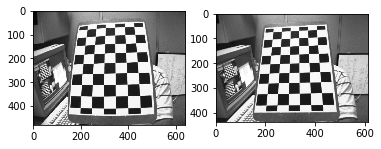

In [24]:
%matplotlib inline
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(dst)

(2) [cv2.remap()](http://docs.opencv.org/3.0-beta/modules/imgproc/doc/geometric_transformations.html?highlight=cv2.remap#cv2.remap) 関数を使う

[cv2.undistort()](http://docs.opencv.org/3.0-beta/modules/imgproc/doc/geometric_transformations.html?highlight=cv2.undistort#cv2.undistort) 関数に比べ，手間のかかる方法である．まず初めに，歪んだ映像を補正するための[cv2.initUndistortRectifyMap(cameraMatrix, distCoeffs, R, newCameraMatrix, size, m1type{, map1{, map2}}](https://docs.opencv.org/3.0-beta/modules/imgproc/doc/geometric_transformations.html?highlight=initundistortrectifymap#cv2.initUndistortRectifyMap)関数を呼び出し，次に[cv2.remap(src, map1, map2, interpolation{, dst{, borderMode{, borderValue}}})](http://docs.opencv.org/3.0-beta/modules/imgproc/doc/geometric_transformations.html?highlight=cv2.remap#cv2.remap)関数によって補正する．

In [25]:
# 歪補正
mapx,mapy = cv2.initUndistortRectifyMap(mtx,dist,None,newcameramtx,(w,h),5)
dst = cv2.remap(img,mapx,mapy,cv2.INTER_LINEAR)

# 画像の切り落とし
x,y,w,h = roi
dst = dst[y:y+h, x:x+w]
cv2.imwrite('calibresult.png',dst)

True

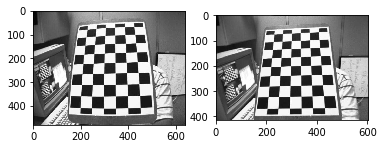

In [26]:
%matplotlib inline
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(dst)

どちらの方法を使っても同じ結果が返る．結果を以下に示す:
![](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/_images/calib_result.jpg)

この結果から，歪み補正により全てのエッジが直線になっていることが分かるだろう．

## 再投映誤差(Re-projection Error)

再投映誤差とは、キャリブレーションによって推定したパラメータを評価する指標の一つである．この評価値が0に近ければ近いほど良いことを意味する．カメラの内部パラメータ，レンズ歪みパラメータ，外部パラメータを与えると，まず初めに対象点の3次元座標(object point)を [cv2.projectPoints()](http://docs.opencv.org/3.0-beta/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html?highlight=cv2.projectpoints#cv2.projectPoints) 関数を使って画像空間に写像(再投映)する．次に，画像上で検出した点の座標と再投映した点の座標の絶対ノルムを計算する．誤差の平均を出すにはキャリブレーション用の全画像の誤差の算術平均を計算する．

In [27]:
import numpy as np
import cv2
import glob

# Load previously saved data
with np.load('B.npz') as X:
    mtx, dist, rvecs, tvecs = [X[i] for i in ('mtx','dist','rvecs','tvecs')]

with np.load('Points.npz') as X:
    objpoints, imgpoints = [X[i] for i in ('objpoints','imgpoints')]

###################

mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i],imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    mean_error += error

print( "total error: ", mean_error/len(objpoints) )

total error:  0.023535261026163958


## 課題
1.円形パターンを使ったカメラ・キャリブレーションを試してみよ．
